In [1]:
from IPython.display import HTML,Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

import warnings
warnings.filterwarnings("ignore")

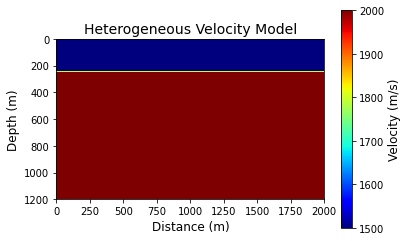

In [2]:
## . . Define spatial grid
Lx,Ly = 2000,1200           # . . lengths (m)
nx,ny = 401,241             # . . Number of points in discretization
dx,dy = Lx/(nx-1),Ly/(ny-1) # . . Discretization intervals

## . . Create velocity function
v = np.zeros((nx,ny))+1500
v[:,50:]=2000

plt.figure()
plt.imshow(v.T,cmap='jet',extent=[0,Lx,Ly,0])
cbar=plt.colorbar()
cbar.set_label('Velocity (m/s)',fontsize=12)
plt.xlabel('Distance (m)',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)
plt.title('Heterogeneous Velocity Model',fontsize=14)
plt.show()

In [3]:
from pdesolver.hyperbolic_hetero import awe_2d_explicit_solver_heterogeneous_8th_order, awe_2d_heterogeneous_8th_order_data_time_reverse

## . . Init wavefields on spatial grid
UUo = np.zeros((nx,ny))
UUm = np.zeros((nx,ny))

## Time stepping parameters
CC = 0.5                     # . . Courant #
nt = 800                     # . . Number of time steps
dt = CC*dx/np.max(v)         # . . Define dt based on Courant
t  = np.linspace(0,nt*dt,nt) # . . Time lin
t0 = 0.05                    # . . Wavelet shift

## . . Define forcing function
ss=0.01                      # . . sigma for Ricker wavelet
F = (1-((t-t0)/ss)**2)*np.exp(-(t-t0)**2/(2*ss**2))

## . . Define source location
sx,sy=Lx/2,25                # . . source x,y location (in physical m units)

## . . Total Solution space
fff = np.zeros((nx,ny,nt))

## . . Iterate over solution
for it in range(nt):
    tmp = awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F,it,sx,sy) #calc solution at n+1
    fff[:,:,it]=tmp  ## save solution vector
    UUm=UUo          ## move solution at n to n-1 to prepare for next iteration
    UUo=tmp          ## move solution at n+1 to n to prepare for next iteration

## . . compute maximum for scaling
amax = np.max(np.abs(fff))

## . . Add (demeaned) velocity model to wavefield to illustrate interactions
vscale = (v.T-np.mean(v))
vscale = -vscale/np.max(vscale)

MovieWriter ffmpeg unavailable; using Pillow instead.


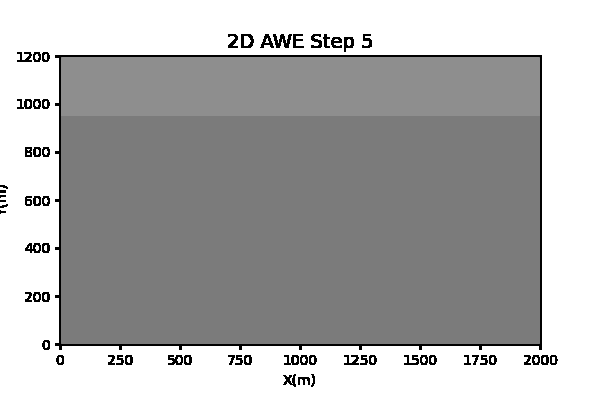

In [4]:
def AWE_2D_animate(i):
    global k
    wfld = fff[:,:,k].T/np.max(np.abs(fff))
    data = wfld+0.0025*vscale[:,::-1]
    ax1.clear()
    ax1.imshow(data,cmap='gray',extent=[0,Lx,0,Ly],vmin=-0.08,vmax=0.08)
    ax1.set(xlabel='X(m)', ylabel='Y(m)')
    ax1.set_title('2D AWE Step %s'%k,fontsize=14)
    k += kskip

## . . Animate Solution and compute error
k,kskip = 0,10

## . . Set up movie
fig7,ax1 = plt.subplots(1)
fig7.subplots_adjust(0.1,0.1,0.9,0.9)
fig7.set_dpi(100)

## . . Call the animator
ani_filename = 'Ex_7.gif'
anim7 = animation.FuncAnimation(fig7,AWE_2D_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim7.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

In [4]:
# implement of reverse solver 
## . . Define spatial grid
Lx,Ly = 2000,1200        # . . length (m)
nx,ny = 401,241      # . . Number of points in discretization
dx = Lx/(nx-1) # . . Discretization interval
dy = Ly/(ny-1) # . . Discretization interval

## . . Create velocity function
v = np.zeros((nx,ny))+1500
v[:,50:]=2000

## . . Init wavefields on spatial grid
UUo = np.zeros((nx,ny))
UUm = np.zeros((nx,ny))

## Time stepping parameters
CC = 0.5                     # . . Courant #
nt = 800                     # . . Number of time steps
dt = CC*dx/np.max(v)         # . . Define dt based on Courant
t  = np.linspace(0,nt*dt,nt) # . . Time lin
t0 = 0.05                    # . . Wavelet shift

## . . Define forcing function
ss=0.01                      # . . sigma for Ricker wavelet

## . . Get the data from fff above
data = fff[:,5,:]

## . . Define source location
ry=25                        # . . receiver injection location in y (in physical m units)

## . . Total Solution space
mmm = np.zeros((nx,ny,nt))

## . . Iterate over solution
## . . Note time reversal
for it in range(nt-1,0,-1):
    tmp = awe_2d_heterogeneous_8th_order_data_time_reverse(UUo,UUm,dx,dy,dt,v,data,it,ry) #calc solution at n+1
    mmm[:,:,nt-1-it]=tmp  ## save solution vector
    UUm=UUo          ## move solution at n to n-1 to prepare for next iteration
    UUo=tmp          ## move solution at n+1 to n to prepare for next iteration

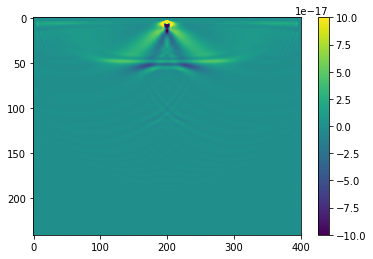

In [6]:
cx = np.array([-1,1])
image = np.sum(fff*mmm[:,:,::-1], axis=2)
plt.imshow(image.T, aspect='auto')
plt.clim(cx * 1e-16)
plt.colorbar()
plt.show()

In [9]:
# 1. generate 30-50 shots on the surface


(2,)